# Logistic Regression Manual Parameter Tuning

All features

Hyperparameter tuning

Up-sample the minority class

Pre-requisite: nommesen_april-week2-prepare_data.ipynb

In [1]:
import pandas as pd
import numpy as np
import math

# SKLearn
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# import xgboost as xgb
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin

import matplotlib.pyplot as plt
import seaborn as sns

import joblib


## Loading the training data set (standardised)

In [2]:
alltrain = np.load('../data/processed/alltrain.npy')

print("Dimension of training data - unsplit", alltrain.shape)

df_alltrain = pd.DataFrame(alltrain, 
             columns=['ID',
                 'Games Played', 
    'Minutes Played',
    'Points Per Game',
    'Field Goals Made',
    'Field Goals Attempts',
    'Field Goals Percent',
    '3Points Made',
    '3Points Attempts',
    '3Points Percent',
    'Free Throw Made',
    'Free Throw Attempts',
    'Free Throw Percent',
    'Offensive Rebounds',
    'Defensive Rebounds',
    'Rebounds',
    'Assists',
    'Steals',
    'Blocks',
    'Turnovers',
     'TARGET_5Yrs'
                     ])

df_alltrain['TARGET_5Yrs'] = df_alltrain['TARGET_5Yrs'].astype(dtype ='int64')
df_alltrain['ID'] = df_alltrain['ID'].astype(dtype ='str')

df_alltrain.head()

Dimension of training data - unsplit (8000, 21)


,ID,Games Played,Minutes Played,Points Per Game,Field Goals Made,Field Goals Attempts,Field Goals Percent,3Points Made,3Points Attempts,3Points Percent,...,Free Throw Attempts,Free Throw Percent,Offensive Rebounds,Defensive Rebounds,Rebounds,Assists,Steals,Blocks,Turnovers,TARGET_5Yrs
0,3799.0,80.0,24.3,7.8,3.0,6.4,45.7,0.1,0.3,22.6,...,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6,1
1,3800.0,75.0,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,34.9,...,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4,1
2,3801.0,85.0,19.1,4.5,1.9,4.5,42.8,0.4,1.2,34.3,...,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6,1
3,3802.0,63.0,19.1,8.2,3.5,6.7,52.5,0.3,0.8,23.7,...,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9,1
4,3803.0,63.0,17.8,3.7,1.7,3.4,50.8,0.5,1.4,13.7,...,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7,1


### Visualise the target variable (imbalanced)

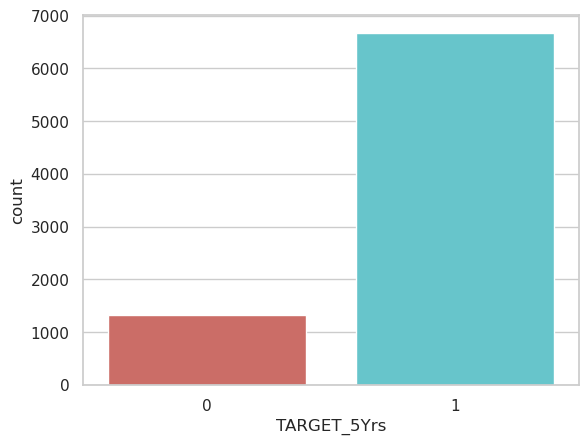

<Figure size 640x480 with 0 Axes>

In [3]:
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

sns.countplot(x = 'TARGET_5Yrs',
              data = df_alltrain,
              palette = 'hls'
             )
plt.show()
plt.savefig('count_plot')

In [4]:
df_alltrain['TARGET_5Yrs'].value_counts()

1    6669
0    1331
Name: TARGET_5Yrs, dtype: int64

In [5]:
count_lt_5Yrs = len(df_alltrain[df_alltrain['TARGET_5Yrs']==0])
count_gt_5Yrs = len(df_alltrain[df_alltrain['TARGET_5Yrs']==1])
pct_of_lt_5Yrs = count_lt_5Yrs/(count_lt_5Yrs+count_gt_5Yrs)
print("Percentage of NBA career less than 5 years is", pct_of_lt_5Yrs*100)
pct_of_gt_5Yrs = count_gt_5Yrs/(count_lt_5Yrs+count_gt_5Yrs)
print("Percentage of NBA career at least 5 years is", pct_of_gt_5Yrs*100)

Percentage of NBA career less than 5 years is 16.6375
Percentage of NBA career at least 5 years is 83.3625


## Splitting data
Split randomly the dataset with random_state=8 into 2 different sets: training data (80%) and validation data (20%)

In [6]:
df_training, df_validation, = train_test_split (df_alltrain, 
                                                   test_size=0.2,
                                                   random_state=8
                                                  )

print("Dimension of training data", df_training.shape)
df_training.info()
print('------------------------------------------------------------------------------------')
print("Dimension of validation data", df_validation.shape)
df_validation.info()

Dimension of training data (6400, 21)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6400 entries, 3617 to 4547
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    6400 non-null   object 
 1   Games Played          6400 non-null   float64
 2   Minutes Played        6400 non-null   float64
 3   Points Per Game       6400 non-null   float64
 4   Field Goals Made      6400 non-null   float64
 5   Field Goals Attempts  6400 non-null   float64
 6   Field Goals Percent   6400 non-null   float64
 7   3Points Made          6400 non-null   float64
 8   3Points Attempts      6400 non-null   float64
 9   3Points Percent       6400 non-null   float64
 10  Free Throw Made       6400 non-null   float64
 11  Free Throw Attempts   6400 non-null   float64
 12  Free Throw Percent    6400 non-null   float64
 13  Offensive Rebounds    6400 non-null   float64
 14  Defensive Rebounds    6400 non-

## Oversample

In [7]:
df_training['TARGET_5Yrs'].value_counts()

1    5326
0    1074
Name: TARGET_5Yrs, dtype: int64

In [8]:


# Separate majority and minority classes
df_majority = df_training[df_training['TARGET_5Yrs']==1]
df_minority = df_training[df_training['TARGET_5Yrs']==0]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=5326,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.TARGET_5Yrs.value_counts()

1    5326
0    5326
Name: TARGET_5Yrs, dtype: int64

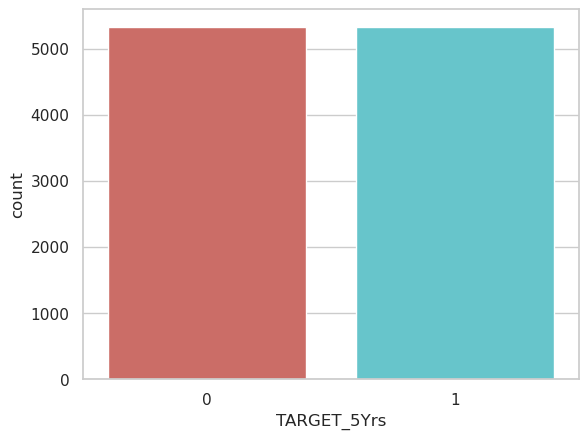

<Figure size 640x480 with 0 Axes>

In [9]:
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

sns.countplot(x = 'TARGET_5Yrs',
              data = df_upsampled,
              palette = 'hls'
             )
plt.show()
plt.savefig('count_plot')

In [10]:
y_train = df_upsampled.pop('TARGET_5Yrs')
X_train_noscale = df_upsampled[['Games Played', 
    'Minutes Played',
    'Points Per Game',
    'Field Goals Made',
    'Field Goals Attempts',
    'Field Goals Percent',
    '3Points Made',
    '3Points Attempts',
    '3Points Percent',
    'Free Throw Made',
    'Free Throw Attempts',
    'Free Throw Percent',
    'Offensive Rebounds',
    'Defensive Rebounds',
    'Rebounds',
    'Assists',
    'Steals',
    'Blocks',
    'Turnovers']]


y_val = df_validation.pop('TARGET_5Yrs')
X_val_noscale = df_validation[['Games Played', 
    'Minutes Played',
    'Points Per Game',
    'Field Goals Made',
    'Field Goals Attempts',
    'Field Goals Percent',
    '3Points Made',
    '3Points Attempts',
    '3Points Percent',
    'Free Throw Made',
    'Free Throw Attempts',
    'Free Throw Percent',
    'Offensive Rebounds',
    'Defensive Rebounds',
    'Rebounds',
    'Assists',
    'Steals',
    'Blocks',
    'Turnovers']]


print("Dimension of features training data", X_train_noscale.shape)
print("Dimension of target training data", y_train.shape)
print("Dimension of features validation data", X_val_noscale.shape)
print("Dimension of targer validation data", y_val.shape)


Dimension of features training data (10652, 19)
Dimension of target training data (10652,)
Dimension of features validation data (1600, 19)
Dimension of targer validation data (1600,)


## Scaling

In [12]:
scaler_stan = StandardScaler()
X_train = scaler_stan.fit_transform(X_train_noscale)
X_val = scaler_stan.fit_transform(X_val_noscale)

In [13]:
scaler_norm = MinMaxScaler()
X_train_norm = scaler_norm.fit_transform(X_train_noscale)
X_val_norm = scaler_norm.fit_transform(X_val_noscale)

## Model Development and Prediction

Using default parameters

### Using default parameters - standardized features (Logreg2)

In [53]:
# instantiate the model (using the default parameters)
logreg2_train = LogisticRegression(random_state=16)

# scaler_stan = StandardScaler()
# X_train = scaler_stan.fit_transform(X_train_noscale)
# X_val = scaler_stan.fit_transform(X_val_noscale)

# fit the model with data
logreg2_train.fit(X_train, y_train)

LogisticRegression(random_state=16)

In [54]:
# save the model to disk
joblib.dump(logreg2_train, '../models/logreg2.sav')

['../models/logreg2.sav']

### Using default parameters - normalized features (Logreg3)

In [79]:
# instantiate the model (using the default parameters)
logreg3_train = LogisticRegression(random_state=16)

# scaler_norm = MinMaxScaler()
# X_train_norm = scaler_norm.fit_transform(X_train_noscale)
# X_val_norm = scaler_norm.fit_transform(X_val_noscale)

# fit the model with data
logreg3_train.fit(X_train_norm, y_train)

LogisticRegression(random_state=16)

In [56]:
# save the model to disk
joblib.dump(logreg3_train, '../models/logreg3.sav')

['../models/logreg3.sav']

### With manual hyperparameter tuning (Logreg4)

In [57]:
# instantiate the model (using the default parameters)
logreg4_train = LogisticRegression(penalty = 'l2', #use L2 regularisation
                           dual = False, #dual problem
                           tol = 0.0001,
                           C = 1.0,
                           fit_intercept = True,
                           intercept_scaling = 1,
                           class_weight = None,
                           random_state = None,
                           solver = 'liblinear',
                           max_iter = 100,
                           multi_class = 'ovr',
                           verbose = 0,
                           warm_start = False,
                           n_jobs = 1,
                           l1_ratio = None
                          )

# fit the model with data
logreg4_train.fit(X_train_norm, y_train)


LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear')

In [58]:
# save the model to disk
joblib.dump(logreg4_train, '../models/logreg4.sav')

['../models/logreg4.sav']

### With manual hyperparameter tuning (Logreg4B)

In [14]:
df_X_train_norm = pd.DataFrame(X_train_norm, 
             columns=['Games Played', 
    'Minutes Played',
    'Points Per Game',
    'Field Goals Made',
    'Field Goals Attempts',
    'Field Goals Percent',
    '3Points Made',
    '3Points Attempts',
    '3Points Percent',
    'Free Throw Made',
    'Free Throw Attempts',
    'Free Throw Percent',
    'Offensive Rebounds',
    'Defensive Rebounds',
    'Rebounds',
    'Assists',
    'Steals',
    'Blocks',
    'Turnovers'
                     ])

df_X_train_norm = df_X_train_norm[['Games Played',
                           'Field Goals Attempts',
                           'Field Goals Percent',
                           '3Points Made',
                           '3Points Attempts']]


df_X_val_norm = pd.DataFrame(X_val_norm, 
             columns=['Games Played', 
    'Minutes Played',
    'Points Per Game',
    'Field Goals Made',
    'Field Goals Attempts',
    'Field Goals Percent',
    '3Points Made',
    '3Points Attempts',
    '3Points Percent',
    'Free Throw Made',
    'Free Throw Attempts',
    'Free Throw Percent',
    'Offensive Rebounds',
    'Defensive Rebounds',
    'Rebounds',
    'Assists',
    'Steals',
    'Blocks',
    'Turnovers'
                     ])

df_X_val_norm = df_X_val_norm[['Games Played',
                           'Field Goals Attempts',
                           'Field Goals Percent',
                           '3Points Made',
                           '3Points Attempts']]

df_X_train_norm.head()

,Games Played,Field Goals Attempts,Field Goals Percent,3Points Made,3Points Attempts
0,0.549618,0.100719,0.493182,0.333333,0.347222
1,0.679389,0.194245,0.534091,0.555556,0.513889
2,0.442748,0.025180,0.343182,0.407407,0.430556
3,0.610687,0.151079,0.434091,0.444444,0.430556
4,0.404580,0.183453,0.472727,0.444444,0.416667


In [24]:
# instantiate the model (using the default parameters)

# logreg4B_train = LogisticRegression(penalty = 'l2', 
#                            dual = False, #dual problem
#                            tol = 0.0001,
#                            C = 0.01,
#                            fit_intercept = True,
#                            intercept_scaling = 1,
#                            class_weight = None,
#                            random_state = None,
#                            solver = 'saga',
#                            max_iter = 100,
#                            multi_class = 'ovr',
#                            verbose = 0,
#                            warm_start = False,
#                            n_jobs = 1,
#                           )



logreg4B_train = LogisticRegression(penalty = 'l2', 
                           dual = False, #dual problem
                           tol = 0.0001,
                           C = 0.01,
                           fit_intercept = True,
                           intercept_scaling = 1,
                           class_weight = None,
                           random_state = None,
                           solver = 'saga',
                           max_iter = 100,
                           multi_class = 'ovr',
                           verbose = 0,
                           warm_start = False,
                           n_jobs = 1,
                          )



# fit the model with data
# logreg4B_train.fit(X_train_norm, y_train)
logreg4B_train.fit(df_X_train_norm, y_train) #selected


LogisticRegression(C=0.01, multi_class='ovr', n_jobs=1, solver='saga', tol=0.1)

In [25]:
# save the model to disk
joblib.dump(logreg4B_train, '../models/logreg4B.sav')

['../models/logreg4B.sav']

### Hyperparameter tuning with Hyperopt (Logreg5)

In [88]:
# Define the search space for xgboost hyperparameters

space={
    # 'penalty' : hp.choice('penalty', ['l1', 'l2', 'none']),
       # 'multi_class' : hp.choice('multi_class', ['auto', 'ovr', 'multinomial']),
       'tol' : hp.choice('tol', ['0.0001', '0.0005', '0.01']),
       # 'C' : hp.choice('C', ['0.0001', '0.0005', '0.01'])
    }


# Define a function called `objective` with the following logics:
# input parameters: hyperparameter seacrh space (`space`)
# logics: train a xgboost model with the search space and calculate the average accuracy score for cross validation with 10 folds
# output parameters: dictionary with the loss score and STATUS_OK


def objective(space):
    from sklearn.model_selection import cross_val_score
       
    logreg= LogisticRegression(
        # penalty = space['penalty'],
                           penalty = 'l2',
                           dual = False, 
                           tol = float(space['tol']),
                            # tol = 0.0001,
                           # C = float(space['C']),
                            C = 1.0, 
                           fit_intercept = True,
                           intercept_scaling = 1,
                           class_weight = None,
                           random_state = None,
                           solver = 'saga',
                           max_iter = 1000,
                           # multi_class = space['multi_class'],
                           multi_class = 'ovr',
                           verbose = 0,
                           warm_start = False,
                           n_jobs = 1,
                           l1_ratio = None
                          )
    
#     logreg = LogisticRegression(penalty = 'l2', #use L2 regularisation
#                            dual = False, #dual problem
#                            tol = 0.0001,
#                            C = 1.0,
#                            fit_intercept = True,
#                            intercept_scaling = 1,
#                            class_weight = None,
#                            random_state = None,
#                            solver = 'liblinear',
#                            max_iter = 100,
#                            multi_class = 'ovr',
#                            verbose = 0,
#                            warm_start = False,
#                            n_jobs = 1,
#                            l1_ratio = None
#                           )
    
    acc = cross_val_score(logreg, X_train_norm, y_train, cv=10, scoring="roc_auc").mean()

    return{'loss': 1-acc, 'status': STATUS_OK }



# Launch Hyperopt search and save the result in a variable called `best`
best = fmin(
    fn=objective,   
    space=space,       
    algo=tpe.suggest,       
    max_evals=5
)


# Print the best set of hyperparameters
print("Best: ", best)


100% 5/5 [00:26<00:00,  5.22s/trial, best loss: 0.296385596703691] 
Best:  {'tol': 0}


In [ ]:
# instantiate the model (Logistic Regression with best set of hyperparameters)
logreg5_train = LogisticRegression(penalty = best['penalty'],
                           dual = False, 
                           # tol = float(space['tol']),
                            tol = 0.0001,
                           # C = float(space['C']),
                            C = 1.0, 
                           fit_intercept = True,
                           intercept_scaling = 1,
                           class_weight = None,
                           random_state = None,
                           solver = 'saga',
                           max_iter = 1000,
                           # multi_class = space['multi_class'],
                           multi_class = 'ovr',
                           verbose = 0,
                           warm_start = False,
                           n_jobs = 1,
                           l1_ratio = None
                          )

# fit the model with data
logreg5_train.fit(X_train_norm, y_train)

## Model Evaluation

#### Using default parameters (Logreg2)

In [59]:
# Load the model from the file 
logreg2_from_joblib = joblib.load('../models/logreg2.sav') 

# Predict on training set
y_pred_ontrain_logreg2 = logreg2_from_joblib.predict(X_train)

# Accuracy on training set
print( accuracy_score(y_pred_ontrain_logreg2, y_train) )

0.6463574915508825


#### Using default parameters (Logreg3)

In [60]:
# Load the model from the file 
logreg3_from_joblib = joblib.load('../models/logreg3.sav') 

# Predict on training set
y_pred_ontrain_logreg3 = logreg3_from_joblib.predict(X_train_norm)

# Accuracy on training set
print( accuracy_score(y_pred_ontrain_logreg3, y_train) )

0.6491738640630867


#### Manual hyperparameter tuning (Logreg4)

In [61]:
# Load the model from the file 
logreg4_from_joblib = joblib.load('../models/logreg4.sav') 

# Predict on training set
y_pred_ontrain_logreg4 = logreg4_from_joblib.predict(X_train_norm)

# Accuracy on training set
print( accuracy_score(y_pred_ontrain_logreg4, y_train) )

0.6494555013143072


#### Manual hyperparameter tuning (Logreg4B)

In [26]:
# Load the model from the file 
logreg4B_from_joblib = joblib.load('../models/logreg4B.sav') 

# Predict on training set
# y_pred_ontrain_logreg4B = logreg4B_from_joblib.predict(X_train_norm)
y_pred_ontrain_logreg4B = logreg4B_from_joblib.predict(df_X_train_norm)

# Accuracy on training set
print( accuracy_score(y_pred_ontrain_logreg4B, y_train) )

0.6228877206158467


### Prediction on valuation set

In [33]:
y_pred_onval_logreg2 = logreg2_train.predict(X_val)

In [34]:
y_pred_onval_logreg3 = logreg3_train.predict(X_val_norm)

In [62]:
y_pred_onval_logreg4 = logreg4_train.predict(X_val_norm)

In [198]:
y_pred_onval_logreg4B = logreg4B_train.predict(X_val_norm)

In [27]:
y_pred_onval_logreg4B = logreg4B_train.predict(df_X_val_norm)

### Confusion Matrix

#### Logreg 2 - Default model hyperparameters

In [35]:
cnf_matrix = metrics.confusion_matrix(y_val, y_pred_onval_logreg2)
cnf_matrix


array([[193,  64],
       [635, 708]])

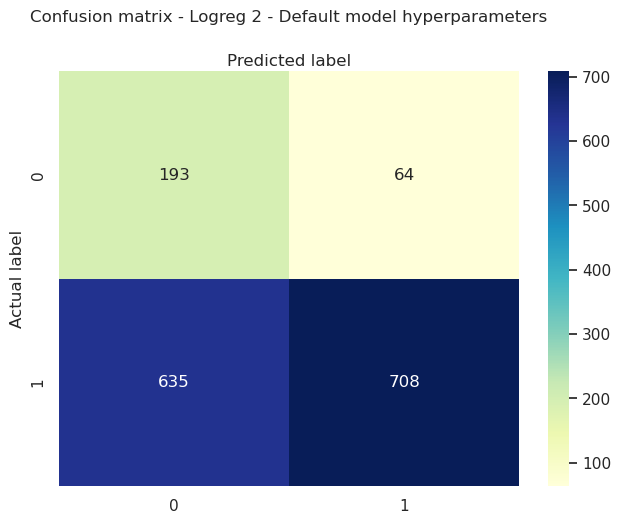

In [36]:
class_names = [0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix - Logreg 2 - Default model hyperparameters', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

#### Logreg 3 - Default model hyperparameters

In [37]:
cnf_matrix = metrics.confusion_matrix(y_val, y_pred_onval_logreg3)
cnf_matrix


array([[175,  82],
       [521, 822]])

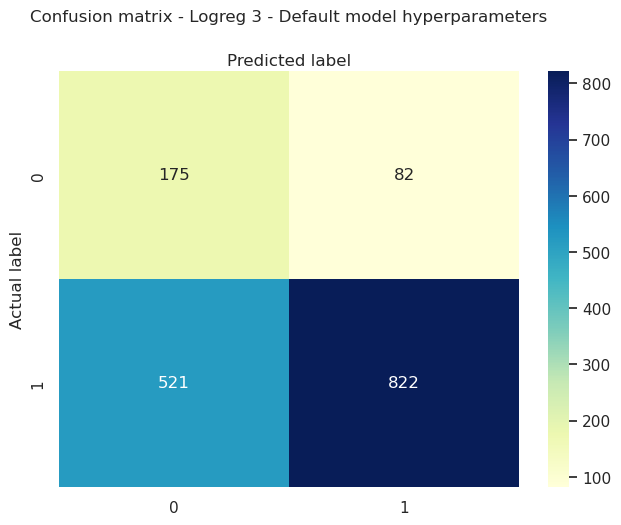

In [38]:
class_names = [0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix - Logreg 3 - Default model hyperparameters', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

#### Logreg 4 - Default model hyperparameters

In [63]:
cnf_matrix = metrics.confusion_matrix(y_val, y_pred_onval_logreg4)
cnf_matrix


array([[180,  77],
       [584, 759]])

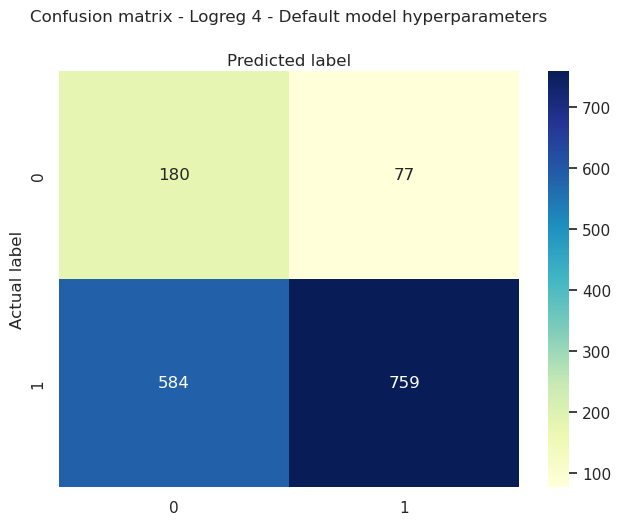

In [64]:
class_names = [0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix - Logreg 4 - Default model hyperparameters', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

#### Logreg 4B - Default model hyperparameters

In [93]:
cnf_matrix = metrics.confusion_matrix(y_val, y_pred_onval_logreg4B)
cnf_matrix


array([[169,  88],
       [543, 800]])

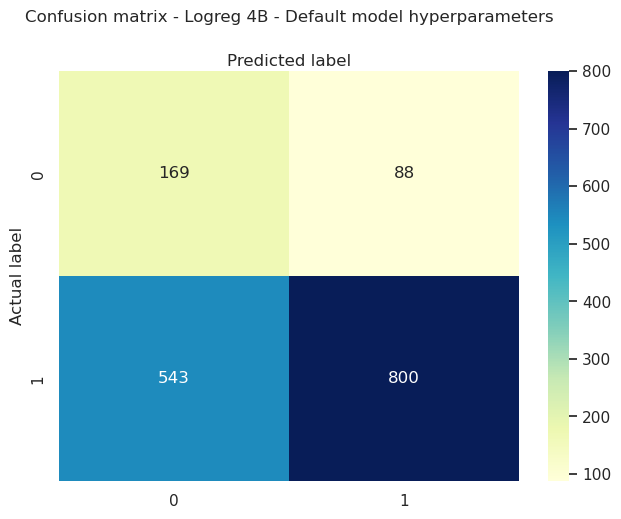

In [94]:
class_names = [0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix - Logreg 4B - Default model hyperparameters', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

### Accuracy, Precision, and Recall

#### Logreg 2 - Default model hyperparameters

In [39]:
target_names = ['career years played < 5', 'career years played >= 5']

In [40]:
print("Logreg 2 - Default model hyperparameters")
print(classification_report(y_val, y_pred_onval_logreg2, target_names=target_names))

Logreg 2 - Default model hyperparameters
                          precision    recall  f1-score   support

 career years played < 5       0.23      0.75      0.36       257
career years played >= 5       0.92      0.53      0.67      1343

                accuracy                           0.56      1600
               macro avg       0.58      0.64      0.51      1600
            weighted avg       0.81      0.56      0.62      1600



#### Logreg 3 - Default model hyperparameters

In [41]:
print("Logreg 3 - Default model hyperparameters")
print(classification_report(y_val, y_pred_onval_logreg3, target_names=target_names))

Logreg 3 - Default model hyperparameters
                          precision    recall  f1-score   support

 career years played < 5       0.25      0.68      0.37       257
career years played >= 5       0.91      0.61      0.73      1343

                accuracy                           0.62      1600
               macro avg       0.58      0.65      0.55      1600
            weighted avg       0.80      0.62      0.67      1600



#### Logreg 4 - Manual hyperparameters tuning

In [65]:
print("Logreg 4 - Manual hyperparameter tuning")
print(classification_report(y_val, y_pred_onval_logreg4, target_names=target_names))

Logreg 4 - Manual hyperparameter tuning
                          precision    recall  f1-score   support

 career years played < 5       0.24      0.70      0.35       257
career years played >= 5       0.91      0.57      0.70      1343

                accuracy                           0.59      1600
               macro avg       0.57      0.63      0.52      1600
            weighted avg       0.80      0.59      0.64      1600



#### Logreg 4B - Manual hyperparameters tuning

In [101]:
print("Logreg 4B - Manual hyperparameter tuning")
print(classification_report(y_val, y_pred_onval_logreg4B, target_names=target_names))

Logreg 4B - Manual hyperparameter tuning
                          precision    recall  f1-score   support

 career years played < 5       0.24      0.74      0.36       257
career years played >= 5       0.91      0.54      0.68      1343

                accuracy                           0.57      1600
               macro avg       0.58      0.64      0.52      1600
            weighted avg       0.81      0.57      0.63      1600



### ROC

#### Logreg 2

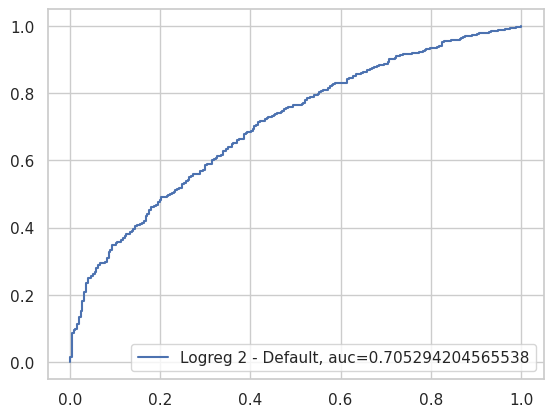

In [42]:
y_proba_onval_logreg2 = logreg2_train.predict_proba(X_val)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_val,  y_proba_onval_logreg2)
auc = metrics.roc_auc_score(y_val, y_proba_onval_logreg2)

plt.plot(fpr,tpr,label="Logreg 2 - Default, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### Logreg 3

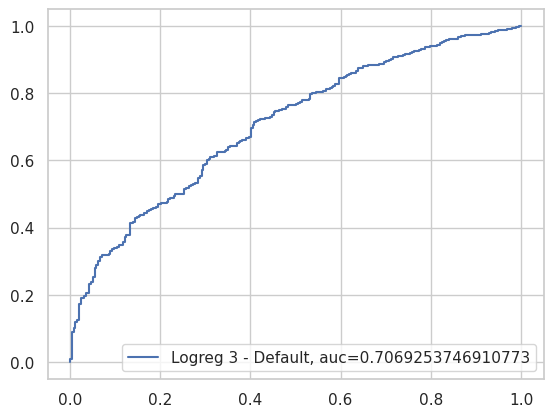

In [66]:
y_proba_onval_logreg3 = logreg3_train.predict_proba(X_val_norm)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_val,  y_proba_onval_logreg3)
auc = metrics.roc_auc_score(y_val, y_proba_onval_logreg3)

plt.plot(fpr,tpr,label="Logreg 3 - Default, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### Logreg 4

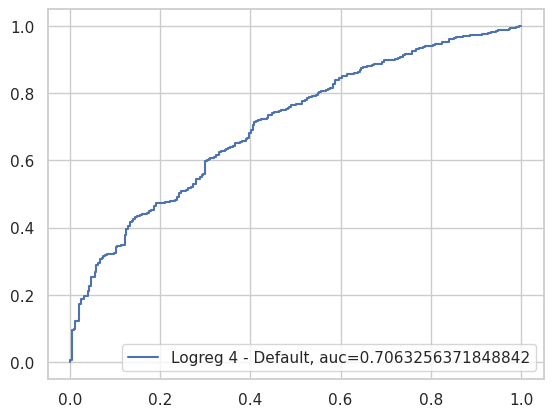

In [67]:
y_proba_onval_logreg4 = logreg4_train.predict_proba(X_val_norm)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_val,  y_proba_onval_logreg4)
auc = metrics.roc_auc_score(y_val, y_proba_onval_logreg4)

plt.plot(fpr,tpr,label="Logreg 4 - Default, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### Logreg 4B

In [ ]:
y_proba_onval_logreg4B = logreg4B_train.predict_proba(X_val_norm)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_val,  y_proba_onval_logreg4B)
auc = metrics.roc_auc_score(y_val, y_proba_onval_logreg4B)

plt.plot(fpr,tpr,label="Logreg 4B - Default, auc="+str(auc))
plt.legend(loc=4)
plt.show()

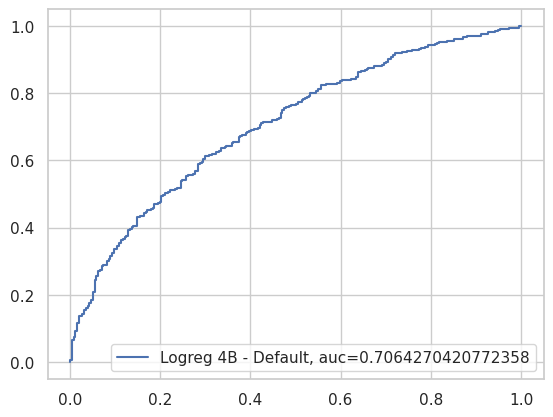

In [28]:
y_proba_onval_logreg4B = logreg4B_train.predict_proba(df_X_val_norm)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_val,  y_proba_onval_logreg4B)
auc = metrics.roc_auc_score(y_val, y_proba_onval_logreg4B)

plt.plot(fpr,tpr,label="Logreg 4B - Default, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Test on unseen data

### Loading the test data set

In [20]:
test = np.load('../data/processed/test.npy')

print("Dimension of training data - unsplit", test.shape)

df_test = pd.DataFrame(test, 
             columns=['ID',
                 'Games Played', 
    'Minutes Played',
    'Points Per Game',
    'Field Goals Made',
    'Field Goals Attempts',
    'Field Goals Percent',
    '3Points Made',
    '3Points Attempts',
    '3Points Percent',
    'Free Throw Made',
    'Free Throw Attempts',
    'Free Throw Percent',
    'Offensive Rebounds',
    'Defensive Rebounds',
    'Rebounds',
    'Assists',
    'Steals',
    'Blocks',
    'Turnovers'
                     ])

df_test['ID'] = df_test['ID'].astype(int)
df_test['ID'] = df_test['ID'].astype(str)

# df_test_indexed=df_test.set_index('ID')

df_test.head()

Dimension of training data - unsplit (3799, 20)


,ID,Games Played,Minutes Played,Points Per Game,Field Goals Made,Field Goals Attempts,Field Goals Percent,3Points Made,3Points Attempts,3Points Percent,Free Throw Made,Free Throw Attempts,Free Throw Percent,Offensive Rebounds,Defensive Rebounds,Rebounds,Assists,Steals,Blocks,Turnovers
0,0,56.0,9.1,4.0,1.6,3.7,43.7,0.1,0.3,7.3,0.7,1.2,63.4,1.2,0.8,1.7,0.4,0.2,0.3,0.8
1,1,43.0,19.3,10.1,3.7,8.1,46.0,0.6,1.7,35.1,1.8,2.5,75.3,0.5,0.9,1.5,3.5,0.6,0.0,1.8
2,2,82.0,33.9,11.3,4.9,10.6,45.6,0.5,1.9,44.8,1.8,2.7,71.2,1.3,3.3,4.5,2.5,1.3,0.3,2.0
3,3,86.0,44.7,18.8,6.8,15.9,42.9,0.5,1.8,13.5,4.5,6.3,70.9,1.5,3.2,5.0,4.1,0.9,0.1,3.6
4,4,58.0,12.3,4.7,1.6,4.0,40.0,0.5,1.7,38.7,1.1,1.3,76.9,0.2,0.6,0.9,1.5,0.5,-0.4,0.9


In [244]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3799 entries, 0 to 3798
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    3799 non-null   object 
 1   Games Played          3799 non-null   float64
 2   Minutes Played        3799 non-null   float64
 3   Points Per Game       3799 non-null   float64
 4   Field Goals Made      3799 non-null   float64
 5   Field Goals Attempts  3799 non-null   float64
 6   Field Goals Percent   3799 non-null   float64
 7   3Points Made          3799 non-null   float64
 8   3Points Attempts      3799 non-null   float64
 9   3Points Percent       3799 non-null   float64
 10  Free Throw Made       3799 non-null   float64
 11  Free Throw Attempts   3799 non-null   float64
 12  Free Throw Percent    3799 non-null   float64
 13  Offensive Rebounds    3799 non-null   float64
 14  Defensive Rebounds    3799 non-null   float64
 15  Rebounds             

In [21]:
df_features_test = df_test[['Games Played', 
    # 'Minutes Played',
    # 'Points Per Game',
    # 'Field Goals Made',
    'Field Goals Attempts',
    'Field Goals Percent',
    '3Points Made',
    '3Points Attempts',
    # '3Points Percent',
    # 'Free Throw Made',
    # 'Free Throw Attempts',
    # 'Free Throw Percent',
    # 'Offensive Rebounds',
    # 'Defensive Rebounds',
    # 'Rebounds',
    # 'Assists',
    # 'Steals',
    # 'Blocks',
    # 'Turnovers'
                           ]]


# scaler_norm = MinMaxScaler()
df_features_test = scaler_norm.fit_transform(df_features_test)



df_features_test

array([[0.41666667, 0.11417323, 0.37575758, 0.42307692, 0.42857143],
       [0.30833333, 0.28740157, 0.42222222, 0.61538462, 0.62857143],
       [0.63333333, 0.38582677, 0.41414141, 0.57692308, 0.65714286],
       ...,
       [0.39166667, 0.03937008, 0.36363636, 0.23076923, 0.3       ],
       [0.69166667, 0.43307087, 0.40606061, 0.57692308, 0.55714286],
       [0.40833333, 0.06692913, 0.34747475, 0.42307692, 0.47142857]])

### Predictions

In [22]:
# Load the model from the file 
# logreg4B_from_joblib = joblib.load('../models/logreg4B.sav') 

# Use the loaded model to make predictions 
y_pred_ontest = logreg4B_from_joblib.predict(df_features_test)

df_test_predictions = pd.DataFrame(y_pred_ontest, columns=['TARGET_5Yrs'])

df_test_predictions.TARGET_5Yrs.value_counts()

/opt/conda/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


0    2559
1    1240
Name: TARGET_5Yrs, dtype: int64

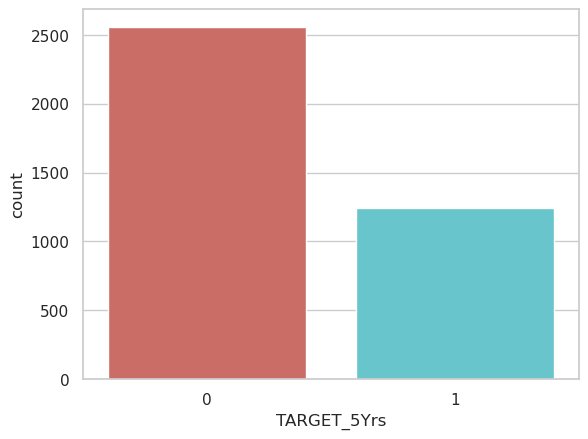

<Figure size 640x480 with 0 Axes>

In [23]:
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

sns.countplot(x = 'TARGET_5Yrs',
              data = df_test_predictions,
              palette = 'hls'
             )
plt.show()
plt.savefig('count_plot')


### Submit Prediction to Kaggle

In [ ]:
# Use the loaded model to make predictions 
y_test = logreg2_from_joblib.predict_proba(df_features_test)

In [ ]:
y_test

In [ ]:
df_test_probabilites = pd.DataFrame(y_test, 
             columns=['TARGET_5Yrs_0',
                 'TARGET_5Yrs'
                     ])

In [ ]:
df_test_probabilites.head()

In [ ]:
output = df_test.join(df_test_probabilites)
output=output.set_index('ID')

output

In [ ]:
# output['TARGET_5Yrs'].to_csv('../models/nommesen_april_week2_model-logreg2.csv')